In [93]:
import pandas as pd
import sqlite3
from pprint import pprint
from tqdm.notebook import tqdm
import sys
sys.path.append("..")

In [150]:
color_map = pd.read_csv("../src/fpl/pipelines/model_pipeline/team_mapping.csv")
color_map = color_map.set_index("FBREF_NAME")["PRIMARY_COLOR"].to_dict()

In [95]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_elos(team_df, x_axis, y_axis, color_by, tooltips):
    fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=x_axis, y_title=y_axis,)
    for idx, axis in enumerate(x_axis):
        fig.add_trace(
            go.Scatter(x=team_df[axis], 
                       y=team_df[y_axis], 
                       marker_color=team_df[color_by], 
                       text=team_df[tooltips].apply(lambda x: '<br>'.join(str(x)), axis=1),
                       showlegend=False,
                       ),
            row=1, col=idx+1)
    fig.update_traces(mode='markers')
    fig.update_layout(height=400, width=1200)
    fig.show()

In [152]:
with sqlite3.connect('../data/fpl.db') as con:
    processed_data = pd.read_sql_query('select * from "02_PROCESSED_DATA"', con)
team_df = processed_data[processed_data["TEAM"]=="Manchester City"].copy()
team_df.loc[team_df.index,"OPPONENT_COLOR"] = team_df["OPPONENT"].map(lambda x: color_map[x])
plot_elos(team_df, ["ATT_TOTAL", "HOME_ATT_TOTAL", "AWAY_ATT_TOTAL"], "XG", "OPPONENT_COLOR", ["OPPONENT", "SEASON", "ROUND"])

In [166]:
numerical_features = ['ROUND', 'POSS', 'DAYS_TILL_NEXT', 'DAYS_SINCE_LAST', 'ATT_TOTAL', 'HOME_ATT_TOTAL', 'AWAY_ATT_TOTAL'] 
# 'DEF_TOTAL', 'HOME_DEF_TOTAL', 'AWAY_DEF_TOTAL', 'DATE', 'XGA', ]
categorical_features = ['VENUE', 'TEAM', 'OPPONENT']
target = "XG"
baseline_columns = ['XG_MA', "TEAM_ODDS_2_SCORE"]

In [167]:
one_hot_encoded_features = pd.get_dummies(processed_data[categorical_features+["index"]])
one_hot_encoded_columns =  [col for col in one_hot_encoded_features.columns if col != 'index']
one_hot_encoded_data = pd.merge(processed_data, one_hot_encoded_features, on="index")
one_hot_encoded_data.head()

,index,SEASON,TEAM,DATE,ROUND,VENUE,GF,GA,OPPONENT,XG,...,OPPONENT_Manchester Utd,OPPONENT_Newcastle Utd,OPPONENT_Norwich City,OPPONENT_Sheffield Utd,OPPONENT_Southampton,OPPONENT_Tottenham,OPPONENT_Watford,OPPONENT_West Brom,OPPONENT_West Ham,OPPONENT_Wolves
0,0,2018-2019,Leicester City,2018-08-10,1,Away,1,2,Manchester Utd,1.8,...,1,0,0,0,0,0,0,0,0,0
1,1,2018-2019,Manchester Utd,2018-08-10,1,Home,2,1,Leicester City,1.5,...,0,0,0,0,0,0,0,0,0,0
2,2,2018-2019,Bournemouth,2018-08-11,1,Home,2,0,Cardiff City,2.2,...,0,0,0,0,0,0,0,0,0,0
3,3,2018-2019,Brighton,2018-08-11,1,Away,0,2,Watford,0.3,...,0,0,0,0,0,0,1,0,0,0
4,4,2018-2019,Cardiff City,2018-08-11,1,Away,0,2,Bournemouth,1.4,...,0,0,0,0,0,0,0,0,0,0


In [168]:
train_data = one_hot_encoded_data[one_hot_encoded_data['SEASON'] < "2021-2022"]
test_data = one_hot_encoded_data[one_hot_encoded_data['SEASON'] >= "2021-2022"]

X_train = train_data[numerical_features+one_hot_encoded_columns]
y_train = train_data[target]

# Separate features and target for the test_data
X_test = test_data[numerical_features+one_hot_encoded_columns]
y_test = test_data[target]

In [169]:
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt

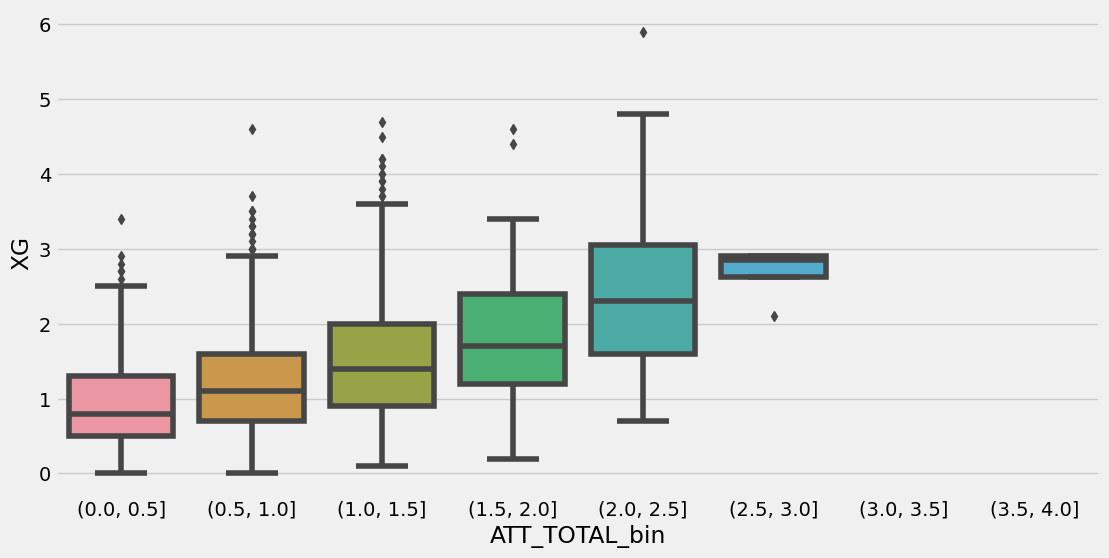

In [170]:
copy_df = train_data[["ATT_TOTAL", "XG"]].copy()
copy_df['ATT_TOTAL_bin'] = pd.cut(copy_df['ATT_TOTAL'], bins=[x/2 for x in range(9)])
plt.figure(figsize=(12, 6))
sns.boxplot(x='ATT_TOTAL_bin', y='XG', data=copy_df)
plt.show()

In [171]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
parameters = dict(random_seed=42, n_estimators=1000, learning_rate=0.01)

In [172]:
xgb_model = xgb.XGBRegressor(
    n_estimators=parameters["n_estimators"],
    learning_rate=parameters["learning_rate"],
    objective ='reg:squarederror', 
    eval_metric='mae', 
    seed=parameters["random_seed"]
    )
xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=100
    )
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Absolute Error: ", mse)

[0]	validation_0-mae:0.87499	validation_1-mae:1.01673


c:\ProgramData\miniconda3\envs\fpl\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[100]	validation_0-mae:0.53862	validation_1-mae:0.65073
[200]	validation_0-mae:0.47324	validation_1-mae:0.58700
[300]	validation_0-mae:0.44920	validation_1-mae:0.57485
[400]	validation_0-mae:0.43284	validation_1-mae:0.57186
[451]	validation_0-mae:0.42461	validation_1-mae:0.57222
Mean Absolute Error:  0.5514650101095785


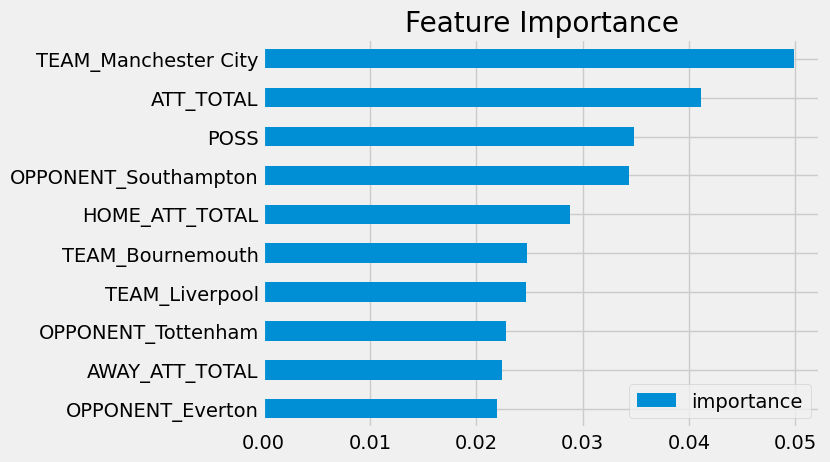

In [173]:
fi = pd.DataFrame(data=xgb_model.feature_importances_,
             index=xgb_model.feature_names_in_,
             columns=['importance'])
fi = fi.sort_values(by='importance', ascending=False).head(10)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

,index,ROUND,POSS,DAYS_TILL_NEXT,DAYS_SINCE_LAST,ATT_TOTAL,HOME_ATT_TOTAL,AWAY_ATT_TOTAL,VENUE,TEAM,OPPONENT,XG,XG_MA,TEAM_ODDS_2_SCORE,prediction,prediction_error,XG_MA_error,TEAM_ODDS_2_SCORE_error
2280,2280,1,64.0,7.0,7.0,NaN,NaN,NaN,Away,Arsenal,Brentford,1.6,1.22,1.111613,1.385985,-0.214015,-0.38,-0.488387
2281,2281,1,36.0,7.0,NaN,NaN,NaN,NaN,Home,Brentford,Arsenal,1.6,NaN,0.754445,0.945053,-0.654947,NaN,-0.845555
2282,2282,1,62.0,7.0,7.0,NaN,NaN,NaN,Away,Aston Villa,Watford,1.3,1.00,1.110384,1.379563,0.079563,-0.30,-0.189616
2283,2283,1,63.0,7.0,7.0,NaN,NaN,NaN,Away,Brighton,Burnley,1.4,0.94,1.029110,1.380649,-0.019351,-0.46,-0.370890
2284,2284,1,37.0,7.0,7.0,NaN,NaN,NaN,Home,Burnley,Brighton,1.4,1.34,0.860952,0.998711,-0.401289,-0.06,-0.539048


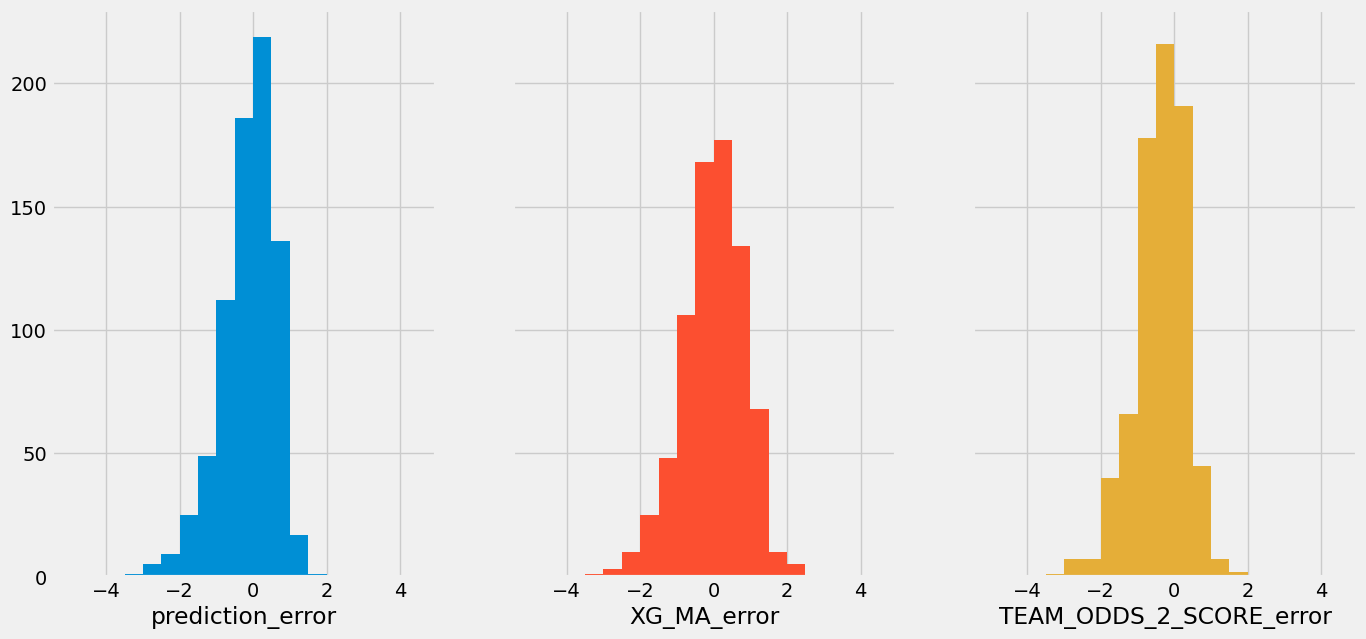

In [174]:
output_cols = ["index"]+numerical_features+categorical_features+[target]+baseline_columns
output_df = test_data[output_cols].copy()
eval_cols = ["prediction"]+baseline_columns
output_df["prediction"] = y_pred

fig, axes = plt.subplots(nrows=1, ncols=len(eval_cols), figsize=(15, 7), sharey=True)

for i, col in enumerate(eval_cols):
    output_df[f"{col}_error"] = output_df[col] - output_df[target]
    # binned = pd.cut(output_df['ATT_TOTAL'], bins=[x/2 for x in range(9)])
    output_df[f"{col}_error"].hist(ax=axes[i], bins=[-5+0.5*i for i in range(20)], color=color_pal[i])
    axes[i].set_xlabel(f"{col}_error")
output_df.head()

In [175]:
with sqlite3.connect('../data/fpl.db') as con:
    fb_ref_teams = pd.read_sql_query('select distinct TEAM from "01_TEAM_MATCH_LOG"', con)["TEAM"]
    odds_portal_teams = pd.read_sql_query('select distinct H_TEAM from "01_MATCH_ODDS"', con)["H_TEAM"]